In [ ]:
# 2020A 1)拟合

In [2]:
import numpy as np

In [3]:
# Celsius
T15 = 175
T6 = 195
T7 = 245
T89 = 255
T1011 = 25
T_env = 25

In [4]:
# centimeter
stove_env = 25
small_room = 30.5
room_interval = 5

In [5]:
T_stove_bs_dif = [
    stove_env,
    small_room * 5 + room_interval * 4, # 1-5 without the last interval
    room_interval, # 5 interval
    small_room, # 6 room
    room_interval, # 6 interval
    small_room, # 7 room
    room_interval, # 7 interval
    small_room * 2 + room_interval, # 8-9 without the last interval
    room_interval, # 9 interval
    small_room * 2 + room_interval, # 10-11 without the last interval
    room_interval + stove_env # 11 interval and the stove-env area
]

In [6]:
T_stove_bs = [0]
for each in T_stove_bs_dif:
    T_stove_bs.append(T_stove_bs[-1] + each)
T_stove_bs

[0, 25, 197.5, 202.5, 233.0, 238.0, 268.5, 273.5, 339.5, 344.5, 410.5, 440.5]

In [7]:
len(T_stove_bs)

12

In [8]:
def T_air(x):
    if T_stove_bs[0] <= x <= T_stove_bs[1]:
        slope = (T15 - T_env) / (T_stove_bs[1] - T_stove_bs[0])
        return slope * (x - T_stove_bs[0]) + T_env
    elif T_stove_bs[1] < x <= T_stove_bs[2]:
        return T15
    elif T_stove_bs[2] < x <= T_stove_bs[3]:
        slope = (T6 - T15) / (T_stove_bs[3] - T_stove_bs[2])
        return slope * (x - T_stove_bs[2]) + T15
    elif T_stove_bs[3] < x <= T_stove_bs[4]:
        return T6
    elif T_stove_bs[4] < x <= T_stove_bs[5]:
        slope = (T7 - T6) / (T_stove_bs[5] - T_stove_bs[4])
        return slope * (x - T_stove_bs[4]) + T6
    elif T_stove_bs[5] < x <= T_stove_bs[6]:
        return T7
    elif T_stove_bs[6] < x <= T_stove_bs[7]:
        slope = (T89 - T7) / (T_stove_bs[7] - T_stove_bs[6])
        return slope * (x - T_stove_bs[6]) + T7
    elif T_stove_bs[7] < x <= T_stove_bs[8]:
        return T89
    elif T_stove_bs[8] < x <= T_stove_bs[9]:
        slope = (T1011 - T89) / (T_stove_bs[9] - T_stove_bs[8])
        return slope * (x - T_stove_bs[8]) + T89
    elif T_stove_bs[9] < x <= T_stove_bs[10]:
        return T1011
    elif T_stove_bs[10] < x <= T_stove_bs[11]:
        slope = (T1011 - T_env) / (T_stove_bs[11] - T_stove_bs[10])
        return slope * (x - T_stove_bs[10]) + T1011

<Axes: >

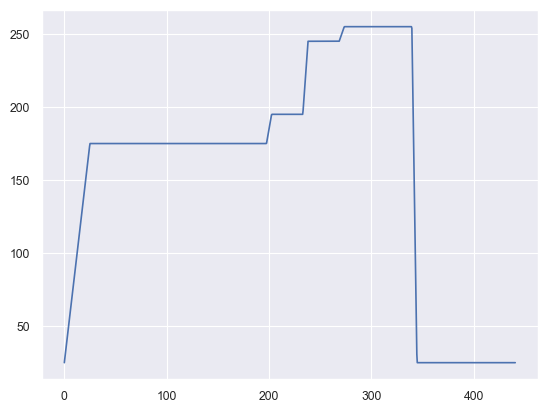

In [9]:
# Plot T for x
import seaborn as sns
sns.set_theme("paper")
x = np.linspace(0, 440.5, 1000)
y = np.vectorize(T_air)(x)
sns.lineplot(x=x, y=y)

In [10]:
# cm / min -> cm / s
speed = 70 / 60
time = T_stove_bs[-1] / speed
dt = 0.1
n_ = int(time / dt)

In [11]:
def get_seg(pos):
    for i in range(1, len(T_stove_bs)):
        if pos < T_stove_bs[i]:
            return int(i - 1)
    return int(len(T_stove_bs) - 1)

In [12]:
def cal(theta):
    T = np.zeros(n_)
    T.fill(T_env)
    theta_over_dt = theta / dt
    for t_ in range(1, n_):
        pos = t_ * dt * speed
        T_a = T_air(pos)
        t = theta_over_dt[get_seg(pos)]
        T[t_] = (T_a + T[t_ - 1] * t) / (1 + t)
    return T

38.303055443438964


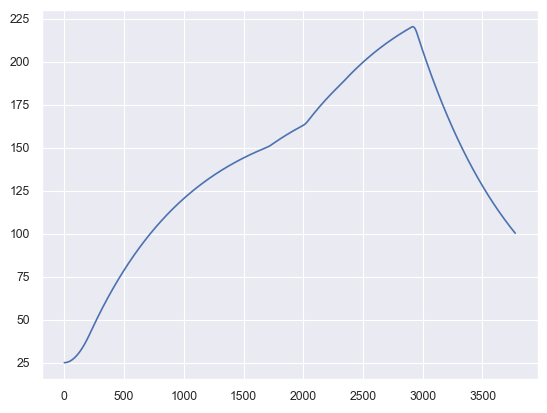

In [13]:
from matplotlib import pyplot as plt

test_T = cal(np.array([88] * len(T_stove_bs)))
# plot test_T
plt.plot(test_T)
# test_T at 19s
print(test_T[int(19 // dt)])

In [14]:
import pandas as pd

reality = pd.read_excel("./附件.xlsx")
reality = reality.rename(columns={
    "时间": "time",
    "温度": "temp"
})
reality.head()

,time,temp
0,19.0,30.03
1,19.5,30.48
2,20.0,30.95
3,20.5,31.44
4,21.0,31.95


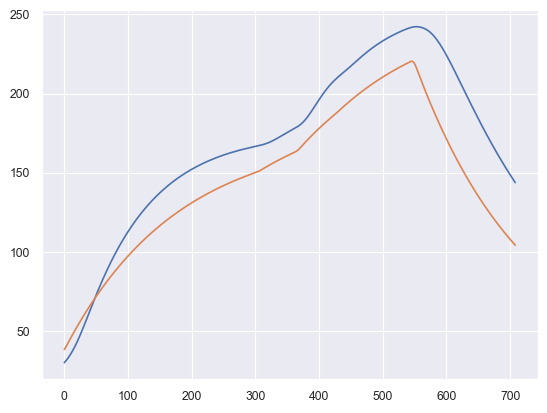

In [15]:
plt.plot(reality['temp'])
plt.plot(test_T[int(19 // dt):int(373 // dt) + 1:int(0.5 // dt) + 1])

In [16]:
reality['temp'].to_numpy().shape

(709,)

In [17]:
test_T[int(19 // dt):int(373 // dt) + 1:int(0.5 // dt) + 1].shape

(709,)

In [18]:
def loss(theta):
    predictions = cal(theta)[int(19 // dt):int(373 // dt) + 1:int(0.5 // dt) + 1]
    # reality step is 0.5s
    # reality starts from 19s
    # reality ends at 373s
    return np.sum((predictions - reality['temp']) ** 2)

In [51]:
# simulated annealing
sim_temp = 0
sim_temp_step = 0.01

ans = np.array([532.23876665,  54.55804656,  51.51008425,  60.64395191,
        73.58904021,  48.13889706, 306.98201478,  36.52734275,
        423.53293641, 168.02540902,  66.58185161,  47.14781481])
ans_loss = loss(ans)
iterations = int(sim_temp // sim_temp_step - 1)
sigma = 5
for i in range(iterations):
    next_ans = ans.copy()
    next_ans += np.random.normal(0, sigma, len(T_stove_bs))
    next_ans = np.clip(next_ans, 0, 1000)
    next_loss = loss(next_ans)
    delta = next_loss - ans_loss
    if delta < 0 or np.random.rand() < np.exp(-delta / sim_temp):
        ans = next_ans
        ans_loss = next_loss
    sim_temp -= sim_temp_step
    if i % (iterations // 10) == 0:
        print('iter', i, 'loss', ans_loss, 'temp', sim_temp)

In [53]:
ans

array([532.23876665,  54.55804656,  51.51008425,  60.64395191,
        73.58904021,  48.13889706, 306.98201478,  36.52734275,
       423.53293641, 168.02540902,  66.58185161,  47.14781481])

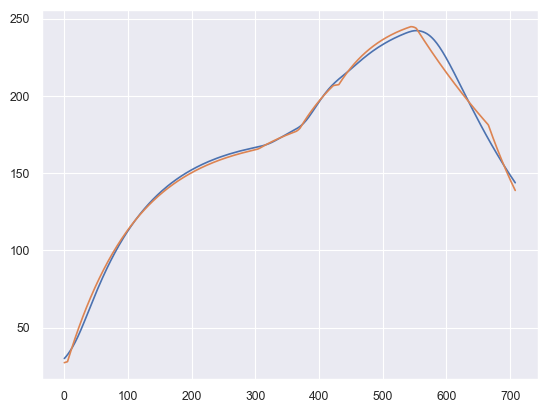

In [61]:
plt.plot(reality['temp'])
plt.plot(cal(ans)[int(19 // dt):int(373 // dt) + 1:int(0.5 // dt) + 1])

In [28]:
n_

3775

In [45]:
def grad(theta):
    eps = np.zeros_like(theta)
    eps_single = 1e-4
    g = np.zeros_like(theta)
    for i in range(len(theta)):
        eps[i] = eps_single
        g[i] = (loss(theta + eps_single) - loss(theta - eps_single)) / (2 * eps_single)
        eps[i] = 0
    return g

In [46]:
grad(ans)

array([0.30655075, 0.30655075, 0.30655075, 0.30655075, 0.30655075,
       0.30655075, 0.30655075, 0.30655075, 0.30655075, 0.30655075,
       0.30655075, 0.30655075])

In [60]:
lr = 1e-2 / 5
ans = np.array([532.23876665,  54.55804656,  51.51008425,  60.64395191,
        73.58904021,  48.13889706, 306.98201478,  36.52734275,
        423.53293641, 168.02540902,  66.58185161,  47.14781481])

iterations = 1000
for i in range(iterations):
    ans -= lr * grad(ans)
    if i % (iterations // 10) == 0:
        print(f'iter {i}')
        print(f'loss: {loss(ans)}')
        print(f'ans: {ans}')

iter 0: 0
loss: 8798.894953797037
ans: [532.23815355  54.55743346  51.50947115  60.64333881  73.58842711
  48.13828396 306.98140168  36.52672965 423.53232331 168.02479592
  66.58123851  47.14720171]
iter 100: 100
loss: 8798.894949869917
ans: [532.23826672  54.55754663  51.50958432  60.64345198  73.58854028
  48.13839713 306.98151485  36.52684282 423.53243648 168.02490909
  66.58135168  47.14731488]
iter 200: 200
loss: 8798.894949870055
ans: [532.23826672  54.55754663  51.50958432  60.64345198  73.58854028
  48.13839713 306.98151485  36.52684282 423.53243648 168.02490909
  66.58135168  47.14731488]
iter 300: 300
loss: 8798.894949869964
ans: [532.23826672  54.55754663  51.50958432  60.64345198  73.58854028
  48.13839713 306.98151485  36.52684282 423.53243648 168.02490909
  66.58135168  47.14731488]
iter 400: 400
loss: 8798.894949869917
ans: [532.23826672  54.55754663  51.50958432  60.64345198  73.58854028
  48.13839713 306.98151485  36.52684282 423.53243648 168.02490909
  66.58135168  47